In [28]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
from pathlib import Path
import pickle
from typing import Dict, List
import mdtraj as md
import pyemma

# Comparison to Xtal structure

In [23]:
protein = '1fme'

data_dir = Path('../data/msms/1fme/metastable_states/')
out_dir = Path(f"{protein}")
xtal_pdb = Path('/Users/robertarbon/Documents/Research/fast_folders/analysis/compare_structures').joinpath(f'{protein}.pdb')

models = [53, 60, 52, 47, 81, 86]
title_by_ix = {53: "1: Best (Dihedrals)", 60: '2: Best (Contacts)', 52: "3: Best (logit(contacts))", 47: '4: Worst (dihedrals)', 81: '5: Best gap (dihedrals)', 86: '7: Best gap (logit(contacts))' }
model_titles = [title_by_ix[i] for i in models]


In [47]:
state_ix = 1
mod_ix = 53

all_dfs = []

for mod_ix in models: 
    for state_ix in [0, 1]:
        traj = md.load(str(data_dir.joinpath(f'hp_{mod_ix}', f'state_{state_ix}.xtc')), top=str(xtal_pdb))

        xtal = md.load(str(xtal_pdb))[0]
        traj = traj.superpose(xtal)
        rmsd = md.rmsd(traj,xtal)*10
        df = pd.DataFrame(dict(rmsd=rmsd))
        if mod_ix ==86:
            df['state'] = ['A', 'B'][state_ix]
        else: 
            df['state'] = ['B', 'A'][state_ix]
        df['model'] = title_by_ix[mod_ix]
        all_dfs.append(df)
df = pd.concat(all_dfs)

/Users/robertarbon/opt/miniconda3/envs/msmsense/lib/python3.8/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


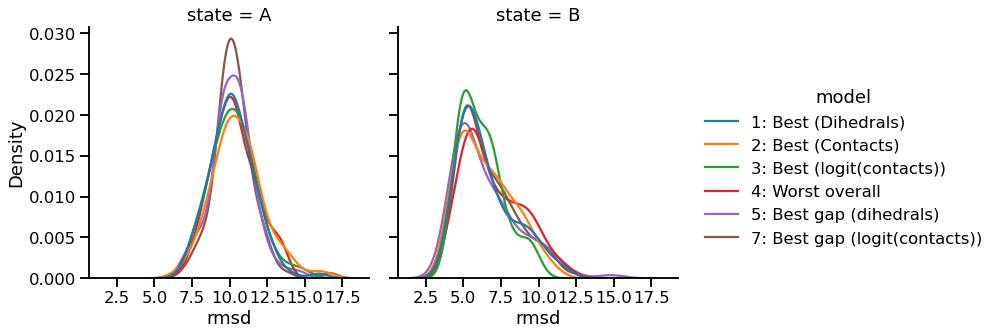

In [48]:
with sns.plotting_context('talk'): 
    g = sns.displot(df,x='rmsd',  hue='model', col='state', kind='kde', col_order=['A', 'B'])
    plt.savefig('/Users/robertarbon/Documents/Talks/2022-03-10-Mey-group/xtal_comparison.pdf', bbox_inches='tight')

# Comparison of populations

In [26]:
root_dir = Path("/Users/robertarbon/Documents/Research/msm_sensitivity_analysis/data/msms")
traj_dir = Path("/Users/robertarbon/Data/DESRES")
title_by_ix = {53: "1: Best (Dihedrals)", 60: '2: Best (Contacts)', 52: "3: Best (logit(contacts))", 47: '4: Worst overall', 81: '5: Best gap (dihedrals)', 86: '7: Best gap (logit(contacts))' }
lag = 41


protein = '1fme'
system_name='BBA'
n_procs = 2

out_dir = Path('/Users/robertarbon/Documents/Talks/2022-03-10-Mey-group/xtal_comparison.pdf', bbox_inches='tight')

top_path = list(traj_dir.rglob(f"*{protein.upper()}*/**/*.pdb"))[0]
assert top_path



In [34]:
all_dfs = []
for hp_ix in models:

    dtraj_paths = list(root_dir.joinpath(protein, 'dtrajs', f"hp_{hp_ix}").glob(f'*{protein.upper()}*.npy'))
    dtrajs = [np.load(str(x)) for x in dtraj_paths]

    mod = pyemma.msm.estimate_markov_model(dtrajs, lag=lag)
    hmm = mod.coarse_grain(n_procs)
    sds = hmm.stationary_distribution
    sds = np.sort(sds)
    if mod_ix ==86:
        df = pd.DataFrame({'$\pi$': sds, 'state': ['A', 'B']})
    else: 
        df = pd.DataFrame({'$\pi$': sds, 'state': ['B', 'A']})
        
    df['model'] = title_by_ix[hp_ix]
    all_dfs.append(df)
df_sds = pd.concat(all_dfs)


10-03-22 10:41:16 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[10] WARNING  Requested coarse-grained model with 2 metastable states at lag=41. The ratio of relaxation timescales between 2 and 3 states is only 1.487481323217264 while we recommend at least 1.5. It is possible that the resulting HMM is inaccurate. Handle with caution.
10-03-22 10:41:31 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[13] WARNING  Requested coarse-grained model with 2 metastable states at lag=41. The ratio of relaxation timescales between 2 and 3 states is only 1.330924289676422 while we recommend at least 1.5. It is possible that the resulting HMM is inaccurate. Handle with caution.


In [38]:
df_sds

,$\pi$,state,model
0,0.287481,A,1: Best (Dihedrals)
1,0.712519,B,1: Best (Dihedrals)
0,0.312757,A,2: Best (Contacts)
1,0.687243,B,2: Best (Contacts)
0,0.298901,A,3: Best (logit(contacts))
1,0.701099,B,3: Best (logit(contacts))
0,0.321969,A,4: Worst overall
1,0.678031,B,4: Worst overall
0,0.324444,A,5: Best gap (dihedrals)
1,0.675556,B,5: Best gap (dihedrals)


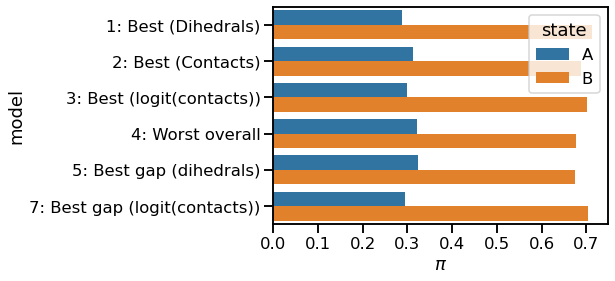

In [46]:
with sns.plotting_context('talk'): 
    g = sns.barplot(data=df_sds, x='$\pi$',  y='model', hue='state', orient='horizontal')
    plt.savefig('/Users/robertarbon/Documents/Talks/2022-03-10-Mey-group/pop_comparison.pdf', bbox_inches='tight')